## 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2.visualize data using line chart
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the  Data

### 1. Importing your libraries and data

#### Install quandl

In [3]:
pip install quandl

In [5]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') 

#### Set Up Quandl API Key

In [6]:
quandl.ApiConfig.api_key = 'your_api_key_here'


In [7]:
# Define path

path = r'C:\Users\Lukman\Desktop\FEMINA CF\Data Immerssion\Achievement6\Analyzing Flight Delays'

In [8]:
# Import Data

df = pd.read_csv(os.path.join(path,'02 Data','Prepared Data','flightdelay_cleaned.csv'))

In [10]:
df.columns

Index(['Unnamed: 0', 'Flight_Date', 'Airline', 'Airline_DOT_Code',
       'Airline_Code', 'Flight_Number', 'Origin_Airport', 'Origin_City',
       'Destination_Airport', 'Destination_City', 'Scheduled_Departure_Time',
       'Actual_Departure_Time', 'Departure_Delay', 'Scheduled_Arrival_Time',
       'Actual_Arrival_Time', 'Arrival_Delay', 'Cancelled',
       'Cancellation_Code', 'Diverted', 'Scheduled_Elapsed_Time',
       'Actual_Elapsed_Time', 'Air_Time', 'Distance', 'Carrier_Delay',
       'Weather_Delay', 'NAS_Delay', 'Security_Delay', 'Late_Aircraft_Delay'],
      dtype='object')

In [11]:
type(df)

pandas.core.frame.DataFrame

In [14]:
# load flight date data
df['Flight_Date'] = pd.to_datetime(df['Flight_Date'])

In [15]:
df.set_index('Flight_Date', inplace=True)

In [16]:
# subset data
df_subset = df[['Departure_Delay', 'Cancelled']].resample('M').mean()  # Resample by month
df_subset = df_subset.reset_index()


### 2.visualize data using line chart

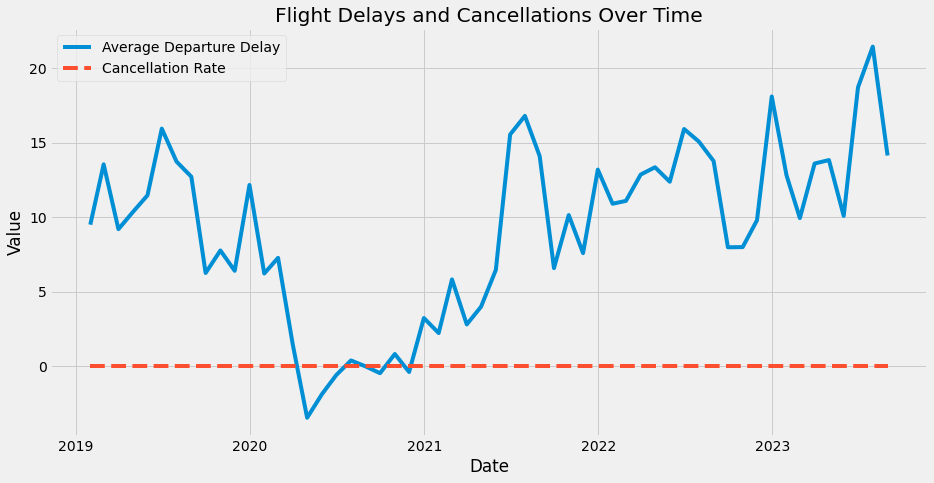

In [17]:

plt.figure(figsize=(14, 7))
plt.plot(df_subset['Flight_Date'], df_subset['Departure_Delay'], label='Average Departure Delay')
plt.plot(df_subset['Flight_Date'], df_subset['Cancelled'], label='Cancellation Rate', linestyle='--')
plt.title('Flight Delays and Cancellations Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### 3. Time-series analysis: decomposition

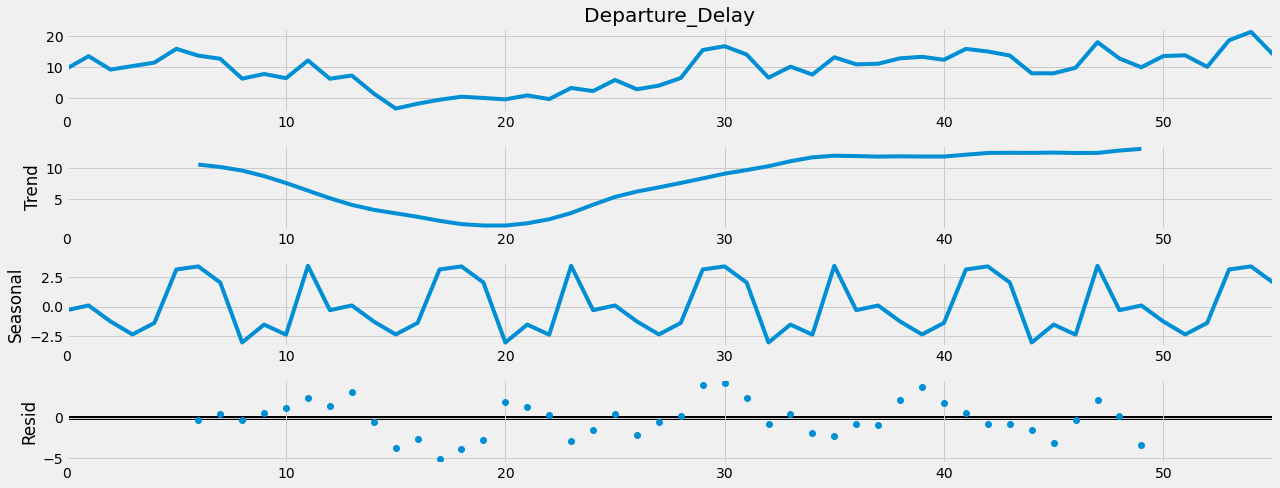

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams # This will define a fixed size for all special charts.

decomposition = seasonal_decompose(df_subset['Departure_Delay'], model='additive', period=12)
rcParams['figure.figsize'] = 18, 7
decomposition.plot()
plt.show()


The trend component shows a slight decline followed by stabilization. This could indicate that, over the analyzed period, there has been an overall improvement in managing departure delays or a change in operational practices that reduced delays.

The seasonal component displays a recurring pattern, which suggests that delays follow a seasonal trend. For instance, delays might increase during certain times of the year, such as winter due to weather-related issues or holidays when air traffic is high.

The residual component represents the irregularities or noise that cannot be explained by the trend or seasonality. The residuals appear relatively small, which indicates that the majority of the variance in Departure_Delay is captured by the trend and seasonal components.

In [22]:
print(df_subset.columns)

Index(['Flight_Date', 'Departure_Delay', 'Cancelled'], dtype='object')


### 4. Testing for stationarity

#### Dickey-Fuller Stationarity test

In [23]:

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_subset['Departure_Delay'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.478723
p-value                         0.120738
Number of Lags Used             0.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


Null Hypothesis : The time series is non-stationary.

The test statistic (-2.478723) is not less than any of the critical values at the 1%, 5%, or 10% levels.

The p-value (0.120738) is greater than 0.05.

Therefore, we fail to reject the null hypothesis, meaning the time series is not stationary.

### Check Autocorrelations

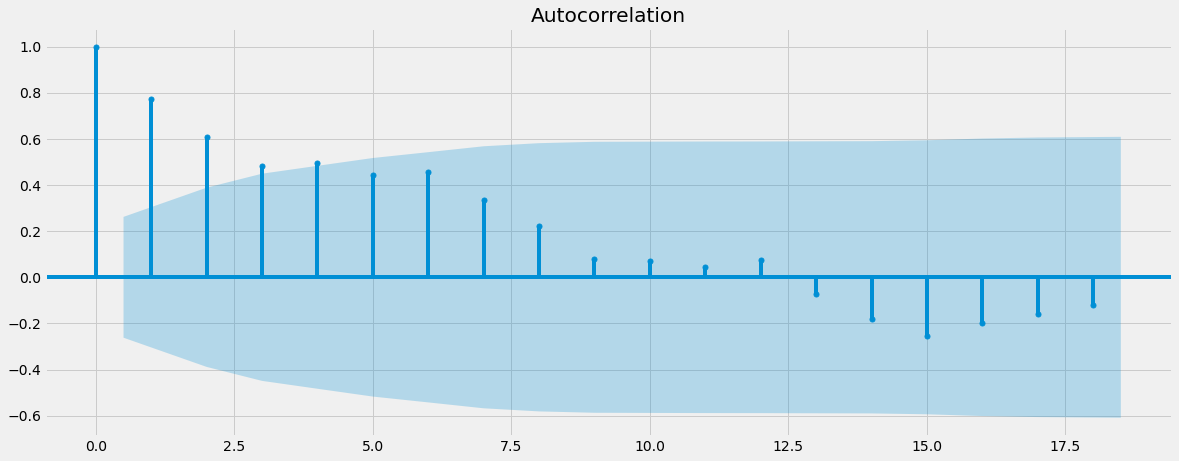

In [29]:
# Extract the numeric series for the departure delay
departure_delay_series = df_subset['Departure_Delay']

# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# Plot autocorrelation function (ACF)
plot_acf(departure_delay_series)  
plt.show()


### 5. Stationarizing the  Data

In [28]:
# Differencing

df_diff = df_subset - df_subset.shift(1)

In [30]:
df_diff.dropna(inplace = True)

In [32]:
df_diff.head()

,Flight_Date,Departure_Delay,Cancelled
1,28 days,4.044039,0.0
2,31 days,-4.344883,0.0
3,30 days,1.135270,0.0
4,31 days,1.135140,0.0
5,30 days,4.467748,0.0


In [35]:
print(df_diff['Departure_Delay'].dtype)


float64


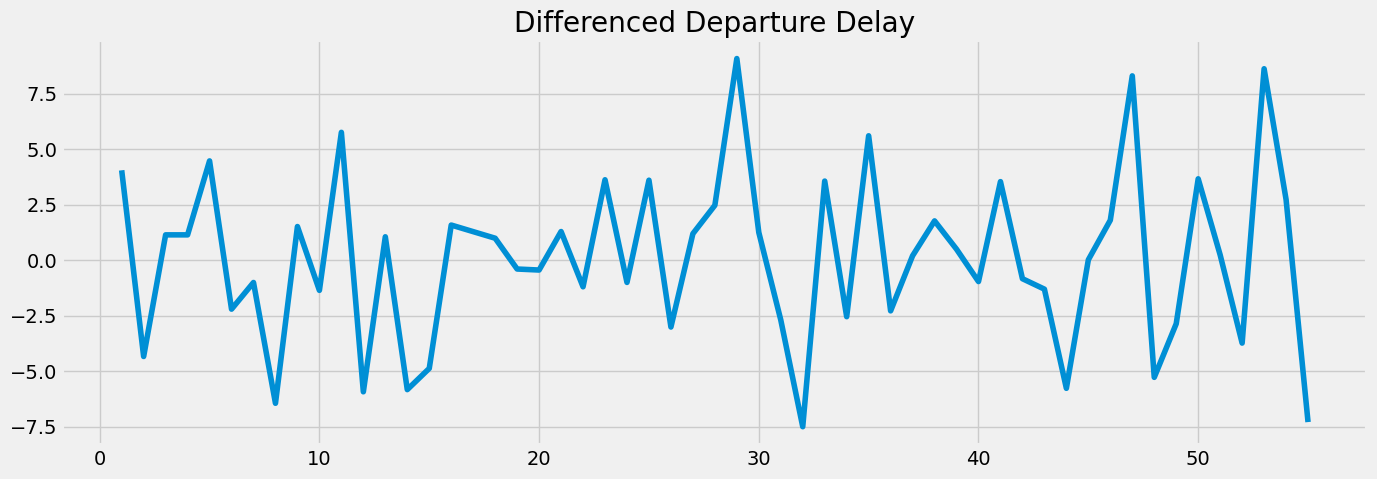

In [36]:
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_diff['Departure_Delay'])
plt.title('Differenced Departure Delay')
plt.show()

In [39]:
dickey_fuller(df_diff['Departure_Delay'])


Dickey-Fuller Stationarity test:
Test Statistic                -6.377243e+00
p-value                        2.267870e-08
Number of Lags Used            2.000000e+00
Number of Observations Used    5.200000e+01
Critical Value (1%)           -3.562879e+00
Critical Value (5%)           -2.918973e+00
Critical Value (10%)          -2.597393e+00
dtype: float64


Since the test statistic -6.377243 is much lower (more negative) than the critical values at the 1%, 5%, and 10% levels, we can reject the null hypothesis of the presence of a unit root. This indicates that the Departure_Delay time series is stationary after differencing.

The p-value is very low. This means that there is strong evidence against the null hypothesis, which assumes that the time series is non-stationary.

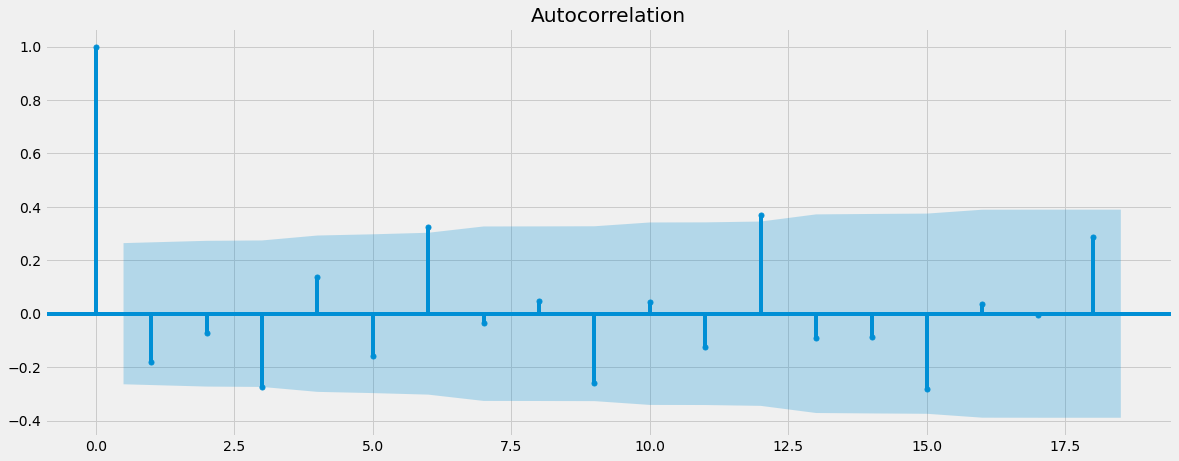

In [40]:
 # Plot autocorrelation function (ACF)
plot_acf(df_diff['Departure_Delay'])  
plt.show()

The autocorrelation plot is perfect now. 